Michail Amasialidis AEM 143

https://github.com/Mickonama/rock-paper-scissors-classification

In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# A few utility functions

- data_augmentation: This function flips the images (horizontally, vertically and both) and adds noise
- random_agent: Randomly flip an image (horizontally or vertically or both) and add noise
- win_condition: Returns 1 if p1 beats p2, returns 0 if it's a tie and returns -1 if p2 beats p1
- play: Implements a game of rocks paper scissors for n rounds against the random_agent

In [34]:
def data_augmentation(X, y, stdev=0.05, add_noise=True):
    """
    This function augments the dataset by flipping the image in every possible direction. Noise can also be added
    :param X: The dataset of images
    :param y: The labels
    :param stdev: The standard deviation for the Gaussian Noise parameter
    :param add_noise: if True a Gaussian Noise will be added to each image
    :return: X_aug, y_aug the augmented dataset
    """
    noise = tf.keras.layers.GaussianNoise(stdev)

    X_aug = tf.concat(
        [X, tf.image.flip_left_right(X), tf.image.flip_up_down(X), tf.image.flip_left_right(tf.image.flip_up_down(X))],
        axis=0)
    y_aug = np.tile(y, 4)
    if add_noise:
        X_aug = noise(X_aug, training=True)
    return X_aug, y_aug

def add_noise(X, stdev=0.05):
    noise = tf.keras.layers.GaussianNoise(stdev)
    return noise(X, training=True)

def random_agent(X):
    noise = tf.keras.layers.GaussianNoise(np.max(X) * 0.05)
    mi = tf.image.random_flip_left_right(X)  # applying horizontal flip with 50% chance (tensorflow's default)
    mi = tf.image.random_flip_up_down(mi)  # applying vertical flip with 50% chance
    mi = noise(mi, training=True)  # applying gaussian noise
    return mi

# 0 rock, 1 scissors, 2 paper
def win_condition(p1, p2):
    if p1 == 0:
        if p2 == 1:
            return 1
        elif p2 == 2:
            return -1
    if p1 == 1:
        if p2 == 0:
            return -1
        elif p2 == 2:
            return 1
    if p1 == 2:
        if p2 == 0:
            return 1
        elif p2 == 1:
            return -1
    return 0

misclass = [] # global list holding the wrong classifications of the previously tested agent
def play(agent, X, y, rounds=100, kpca=None, verbose=True):
    """
    This function simulates a game of rock paper scissors between a trained agent and a random agent opponent.
    The game is played in rounds and the outcome of each round is loss (-1 score), win (+1 score) or (+0 score) a tie.
    :param agent: The trained agent
    :param X: Dataset from which the random agent draws its move
    :param y: Dataset labels
    :param rounds: Number of rounds to play
    :param kpca: If None then a CNN agent is assumed and X is 2D, if kpca transformer is provided then X is 1D. Only use None if agent is a CNN
    :param verbose: True to print the result of each round, False only print the total wins, losses, ties and score
    :return: a list with the accumulated score per round
    """
    score = 0
    wins = 0
    losses = 0
    ties = 0
    score_list = []
    label_name = {0: 'rock', 1: 'scissors', 2: 'paper'}
    for i in range(rounds):
        index = np.random.randint(0, X.shape[0])

        sample = random_agent(X[index])
        if kpca is None:
            sample = sample[np.newaxis, ...]
        comp_action = y[index]  # Competitor's action

        prediction = 0
        if kpca is None:
            prediction = np.argmax(agent.predict(sample, verbose=0), axis=1).item()
        else:
            sample = tf.reshape(sample, [1, -1])
            sample = kpca.transform(sample)
            prediction = agent.predict(sample).item()

        action = 0  # Agent's action
        if prediction == 2:
            action = 1
        elif prediction == 0:
            action = 2

        reward = win_condition(action, comp_action)

        score += reward
        score_list.append(score)
        if reward == 1:
            wins += 1
            if verbose:
                print(f"Round {i} won ({label_name[action]} beats {label_name[comp_action]}), score: {score}")
        elif reward == 0:
            ties += 1
            misclass.append((X[index], sample, prediction))
            if verbose:
                print(f'It\'s a tie!, score: {score}')
        else:
            losses += 1
            misclass.append((X[index], sample, prediction))
            if verbose:
                print(f"Round {i} lost ({label_name[action]} beaten by {label_name[comp_action]}), score: {score}")


    print()
    print('Total score:', score)
    print('Wins:', wins)
    print('Losses:', losses)
    print('Ties:', ties)

    return score_list

# Reading the dataset

In [3]:
X = []
y = []
for ci, c in enumerate(['rock', 'scissors', 'paper']):  # Rock 0, Scissors: 1, Paper: 2
    for im_path in glob.glob(f"{c}/*.png"):
        im = cv2.imread(im_path)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im = np.float32(cv2.resize(im, (120, 80), interpolation=cv2.INTER_AREA)) / 255.0  # Normalization
        X.append(im)
        y.append(ci)
X = np.array(X)
y = np.array(y)

# Image flipping and noise showcase

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


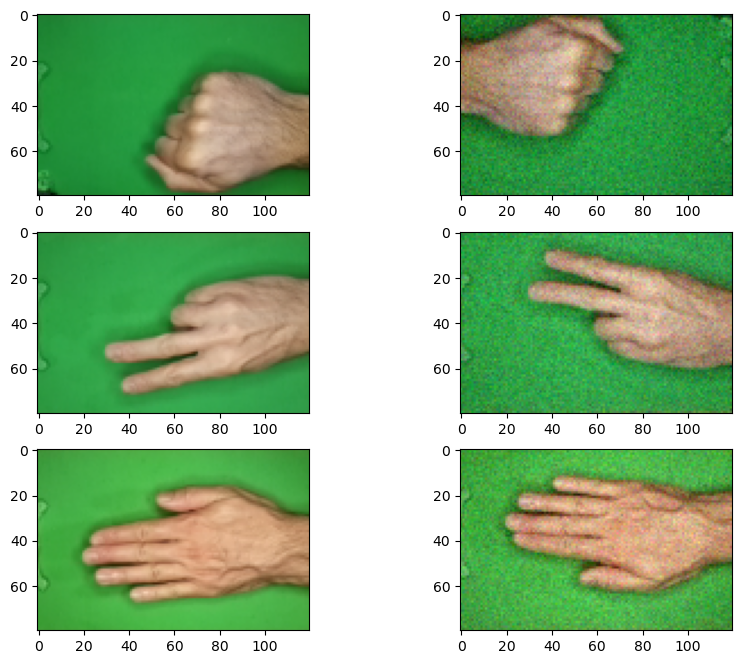

In [61]:
flip = tf.keras.layers.RandomFlip()
noise = tf.keras.layers.GaussianNoise(0.05)
d = flip(X[0], training=True)
d = noise(d, training=True)

fig, axes = plt.subplots(3, 2, figsize=(10, 8))
axes[0, 0].imshow(X[0])
axes[0, 1].imshow(d)


x = X[y == 1][0]
d = flip(x, training=True)
d = noise(d, training=True)
axes[1, 0].imshow(x)
axes[1, 1].imshow(d)

x = X[y == 2][0]
d = flip(x, training=True)
d = noise(d, training=True)
axes[2, 0].imshow(x)
axes[2, 1].imshow(d)

# Train-Test Split and data augmentation

In [4]:
print(X.shape)
# 70-30% train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, stratify=y, random_state=42)
print(X_train.shape, X_test.shape)
# Here we augment the train set by adding flipped images (horizontally, vertically and both) and noise
X_train, y_train = data_augmentation(X_train, y_train, add_noise=False)
print(X_train.shape, X_test.shape, X.shape)
print(X_test[y_test == 0].shape, X_test[y_test == 1].shape, X_test[y_test == 2].shape)

X_train[y_train == 0].shape, X_train[y_train == 1].shape, X_train[y_train == 2].shape

(2188, 80, 120, 3)
(1531, 80, 120, 3) (657, 80, 120, 3)
(6124, 80, 120, 3) (657, 80, 120, 3) (2188, 80, 120, 3)
(218, 80, 120, 3) (225, 80, 120, 3) (214, 80, 120, 3)


(TensorShape([2032, 80, 120, 3]),
 TensorShape([2100, 80, 120, 3]),
 TensorShape([1992, 80, 120, 3]))

# Dimensionality reduction with KPCA (after adding noise and flatten)

Due to the high number of features, in order to reduce the complexity of the dataset and also "select" features of greater importance, we apply KPCA. This is extremely useful in our case as it can both increase the performance and time efficiency during training.

In [19]:
X_train_noised = add_noise(X_train)

In [25]:
X_train_flat = tf.reshape(X_train_noised, [X_train_noised.shape[0], -1])
X_test_flat = tf.reshape(X_test, [X_test.shape[0], -1])
print(X_train_flat.shape, X_test_flat.shape)

kpca = KernelPCA(kernel='rbf')
X_train_flat_t = kpca.fit_transform(X_train_flat)
X_test_flat_t = kpca.transform(X_test_flat)

(6124, 28800) (657, 28800)


# Testing SVM classifier

We grid search over the SVC parameters

In [26]:
param_grid = {'C': [0.5, 1.0, 5.0, 20.0], 'kernel': ['rbf'], 'gamma': ['scale', 'auto']}
gscv = GridSearchCV(SVC(), param_grid, scoring='accuracy', verbose=1, n_jobs=-1)
gscv.fit(X_train_flat_t[:1000], y_train[:1000])

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.5, 1.0, 5.0, 20.0], 'gamma': ['scale', 'auto'],
                         'kernel': ['rbf']},
             scoring='accuracy', verbose=1)

In [27]:
print('Best SVC parameters:', gscv.best_params_)

Best SVC parameters: {'C': 5.0, 'gamma': 'scale', 'kernel': 'rbf'}


# Fitting the SVM with the best parameters

In [28]:
svm_agent = SVC(C=5.0, gamma='scale', kernel='rbf')
svm_agent.fit(X_train_flat_t, y_train)

SVC(C=5.0)

In [29]:
print('Accuracy score of best SVC:', accuracy_score(y_test, gscv.best_estimator_.predict(X_test_flat_t)))

Accuracy score of best SVC: 0.958904109589041


# SVM agent playing

In [30]:
svm_scores = play(svm_agent, X_test, y_test, rounds=200, kpca=kpca)

Round 0 won (paper beats rock), score: 1
Round 1 won (scissors beats paper), score: 2
Round 2 won (scissors beats paper), score: 3
Round 3 won (scissors beats paper), score: 4
Round 4 won (rock beats scissors), score: 5
Round 5 won (paper beats rock), score: 6
Round 6 won (rock beats scissors), score: 7
Round 7 won (rock beats scissors), score: 8
Round 8 won (paper beats rock), score: 9
Round 9 won (paper beats rock), score: 10
Round 10 won (scissors beats paper), score: 11
Round 11 won (rock beats scissors), score: 12
Round 12 won (scissors beats paper), score: 13
Round 13 won (paper beats rock), score: 14
Round 14 won (rock beats scissors), score: 15
Round 15 won (rock beats scissors), score: 16
Round 16 won (scissors beats paper), score: 17
Round 17 won (paper beats rock), score: 18
Round 18 won (paper beats rock), score: 19
Round 19 won (scissors beats paper), score: 20
Round 20 won (rock beats scissors), score: 21
Round 21 won (paper beats rock), score: 22
Round 22 won (paper beat

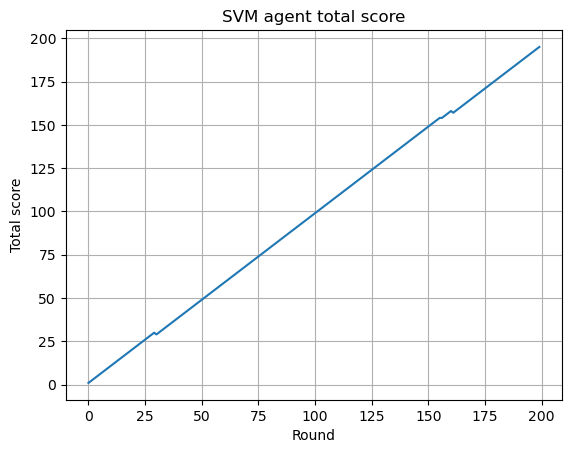

In [50]:
plt.grid()
plt.xlabel('Round')
plt.ylabel('Total score')
plt.title('SVM agent total score')
plt.plot(svm_scores)

Because of KPCA, SVM has a really slow prediction time. However, it has an accuracy of 95% on the test set and performs well against the random agent. (195 total score, 197 wins, 2 losses, 1 tie)

# Testing Random Forest Classifier

In [55]:
rf_agent = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rf_agent.fit(X_train_flat_t, y_train)

RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [57]:
print('Accuracy score of Random Forest agent:', accuracy_score(y_test, rf_agent.predict(X_test_flat_t)))

Accuracy score of Random Forest agent: 0.9421613394216134


In [58]:
rf_scores = play(rf_agent, X_test, y_test, rounds=200, kpca=kpca)

Round 0 won (paper beats rock), score: 1
Round 1 won (paper beats rock), score: 2
Round 2 won (rock beats scissors), score: 3
Round 3 won (rock beats scissors), score: 4
Round 4 won (scissors beats paper), score: 5
Round 5 won (paper beats rock), score: 6
Round 6 won (paper beats rock), score: 7
Round 7 won (paper beats rock), score: 8
Round 8 won (rock beats scissors), score: 9
Round 9 won (rock beats scissors), score: 10
Round 10 won (paper beats rock), score: 11
Round 11 won (rock beats scissors), score: 12
Round 12 won (scissors beats paper), score: 13
Round 13 won (rock beats scissors), score: 14
Round 14 won (rock beats scissors), score: 15
Round 15 won (paper beats rock), score: 16
Round 16 won (paper beats rock), score: 17
Round 17 won (rock beats scissors), score: 18
Round 18 won (paper beats rock), score: 19
Round 19 won (scissors beats paper), score: 20
Round 20 won (paper beats rock), score: 21
Round 21 won (rock beats scissors), score: 22
Round 22 won (rock beats scissors)

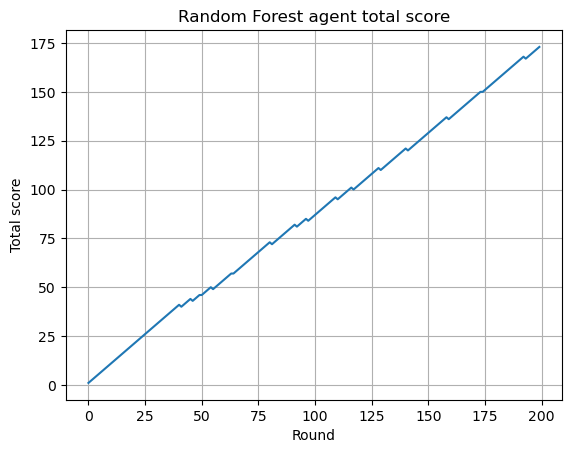

In [59]:
plt.grid()
plt.xlabel('Round')
plt.ylabel('Total score')
plt.title('Random Forest agent total score')
plt.plot(rf_scores)

The Random Forest agent performed a bit worse than the SVM agent

# CNN agent playing

We train a CNN agent on the augmented dataset. Noise is added through the GaussianNoise layer.
One of the reasons for choosing CNN is their ability to perform extremely well on image datasets

In [5]:
agent_cnn = tf.keras.Sequential([
    tf.keras.layers.GaussianNoise(0.05),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])
agent_cnn.build(X_train.shape)

print(agent_cnn.summary())
agent_cnn.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
agent_cnn.fit(X_train, y_train, epochs=20, batch_size=200, validation_data=(X_test, y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise_1 (GaussianN  (6124, 80, 120, 3)       0         
 oise)                                                           
                                                                 
 conv2d (Conv2D)             (6124, 80, 120, 16)       448       
                                                                 
 max_pooling2d (MaxPooling2D  (6124, 40, 60, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (6124, 40, 60, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (6124, 20, 30, 32)       0         
 2D)                                                             
                                                        

In [22]:
print('CNN validation score:', accuracy_score(y_test, np.argmax(agent_cnn.predict(X_test), axis=1)))

21/21 [==============================] - 1s 31ms/step
CNN validation score: 0.9878234398782344


In [23]:
cnn_scores = play(agent_cnn, X_test, y_test, rounds=1000, kpca=None)

Round 0 won (rock beats scissors), score: 1
Round 1 won (rock beats scissors), score: 2
Round 2 won (rock beats scissors), score: 3
Round 3 won (rock beats scissors), score: 4
Round 4 won (rock beats scissors), score: 5
Round 5 won (rock beats scissors), score: 6
Round 6 won (scissors beats paper), score: 7
Round 7 won (paper beats rock), score: 8
Round 8 won (scissors beats paper), score: 9
Round 9 won (scissors beats paper), score: 10
Round 10 won (rock beats scissors), score: 11
Round 11 won (paper beats rock), score: 12
Round 12 won (scissors beats paper), score: 13
Round 13 won (rock beats scissors), score: 14
Round 14 won (scissors beats paper), score: 15
Round 15 won (paper beats rock), score: 16
Round 16 won (scissors beats paper), score: 17
Round 17 won (paper beats rock), score: 18
Round 18 won (rock beats scissors), score: 19
Round 19 won (paper beats rock), score: 20
Round 20 won (rock beats scissors), score: 21
Round 21 won (paper beats rock), score: 22
Round 22 won (paper

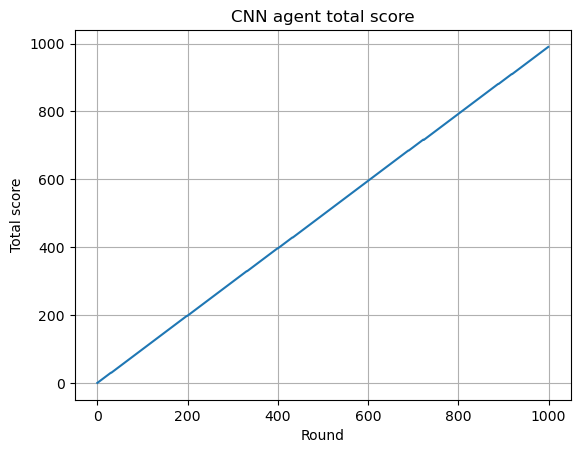

In [24]:
plt.grid()
plt.xlabel('Round')
plt.ylabel('Total score')
plt.title('CNN agent total score')
plt.plot(cnn_scores)

The CNN agent scored an accuracy score of 98% on the test set and performs extremely well when playing against the random agent. It wins around 991/1000 rounds with a total score of 990

# Cases of wrong classification

In [35]:
_ = play(agent_cnn, X_test, y_test, 200, verbose=False)


Total score: 193
Wins: 196
Losses: 3
Ties: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


First case predicted 0
Second case predicted 2


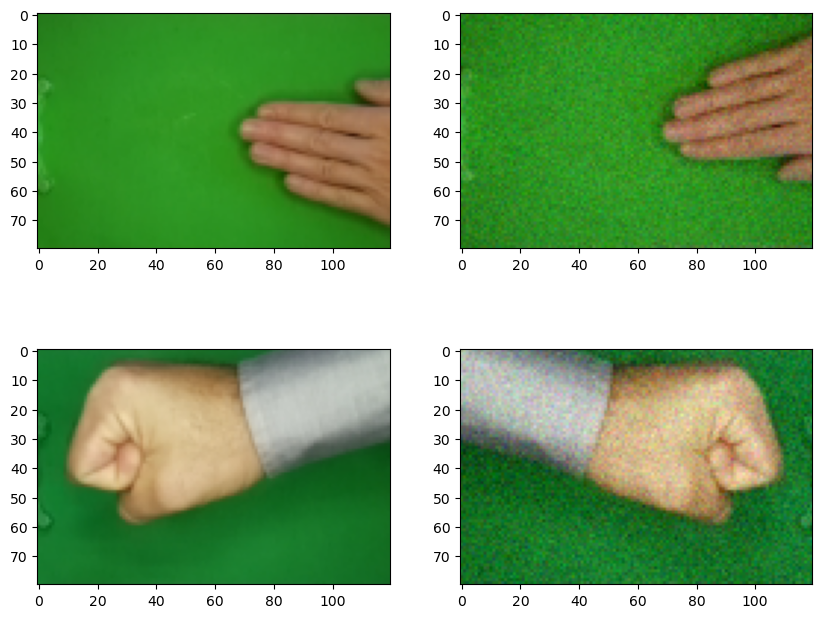

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes[0, 0].imshow(misclass[0][0])
axes[0, 1].imshow(np.squeeze(misclass[0][1]))

axes[1, 0].imshow(misclass[2][0])
axes[1, 1].imshow(np.squeeze(misclass[2][1]))

print(f'First case predicted {misclass[0][2]}')
print(f'Second case predicted {misclass[2][2]}')

In the cases above, the agent made wrong predictions. On the left side it's the original image and on the right side it's the image provided by the random agent.

Specifically, for the first case, the agent predicted a rock when the image shows a paper gesture. Half of the hand in the image is off the frame, this is perhaps the reason from the wrong classification.

In the second case the agent predicted paper instead of rock. The sleeve of the shirt which has a darker colour, and it's not common in the dataset, is also visible in the image. The interfering sleeve might be the reason for this misclassification

# Trying out a different dataset

https://www.kaggle.com/datasets/yash811/rockpaperscissors

In [31]:
X_new = []
y_new = []
for ci, c in enumerate(['rock', 'scissors', 'paper']):  # Rock 0, Scissors: 1, Paper: 2
    for im_path in glob.glob(f"new_dataset/{c}/*.jpg"):
        im = cv2.imread(im_path)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im = np.float32(cv2.resize(im, (120, 80), interpolation=cv2.INTER_AREA)) / 255.0  # Normalization
        X_new.append(im)
        y_new.append(ci)
X_new = np.array(X_new)
y_new = np.array(y_new)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


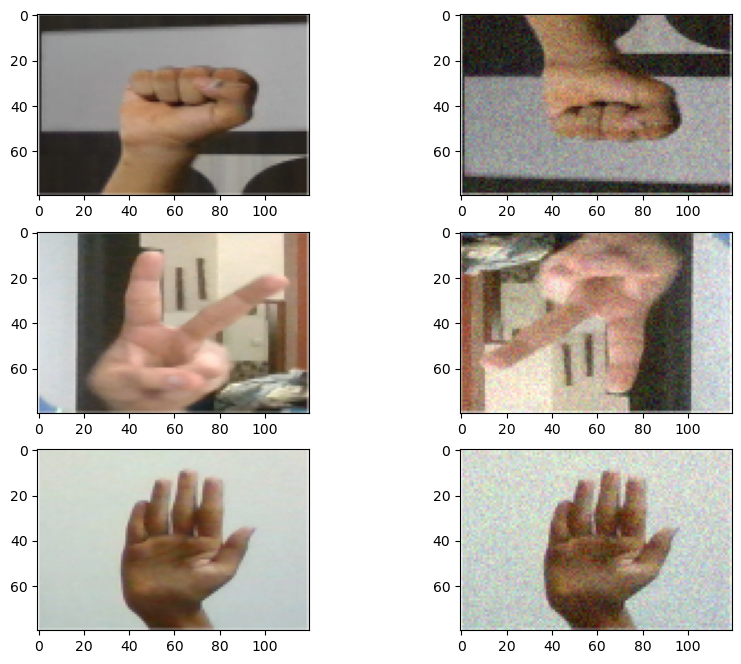

In [64]:
flip = tf.keras.layers.RandomFlip()
noise = tf.keras.layers.GaussianNoise(0.05)


fig, axes = plt.subplots(3, 2, figsize=(10, 8))

x = X_new[y_new == 0][0]
d = flip(x, training=True)
d = noise(d, training=True)
axes[0, 0].imshow(x)
axes[0, 1].imshow(d)

x = X_new[y_new == 1][0]
d = flip(x, training=True)
d = noise(d, training=True)
axes[1, 0].imshow(x)
axes[1, 1].imshow(d)

x = X_new[y_new == 2][0]
d = flip(x, training=True)
d = noise(d, training=True)
axes[2, 0].imshow(x)
axes[2, 1].imshow(d)

# Testing the CNN agent with the new dataset

In [49]:
cnn_scores_new = play(agent_cnn, X_new, y_new, rounds=500)

It's a tie!, score: 0
Round 1 lost (scissors beaten by rock), score: -1
Round 2 won (scissors beats paper), score: 0
Round 3 won (scissors beats paper), score: 1
It's a tie!, score: 1
Round 5 lost (scissors beaten by rock), score: 0
Round 6 won (scissors beats paper), score: 1
It's a tie!, score: 1
Round 8 lost (scissors beaten by rock), score: 0
It's a tie!, score: 0
It's a tie!, score: 0
Round 11 won (scissors beats paper), score: 1
It's a tie!, score: 1
It's a tie!, score: 1
It's a tie!, score: 1
Round 15 won (scissors beats paper), score: 2
Round 16 lost (scissors beaten by rock), score: 1
Round 17 lost (scissors beaten by rock), score: 0
Round 18 lost (scissors beaten by rock), score: -1
Round 19 won (scissors beats paper), score: 0
Round 20 lost (scissors beaten by rock), score: -1
Round 21 lost (scissors beaten by rock), score: -2
Round 22 won (scissors beats paper), score: -1
It's a tie!, score: -1
Round 24 lost (scissors beaten by rock), score: -2
Round 25 lost (scissors beate

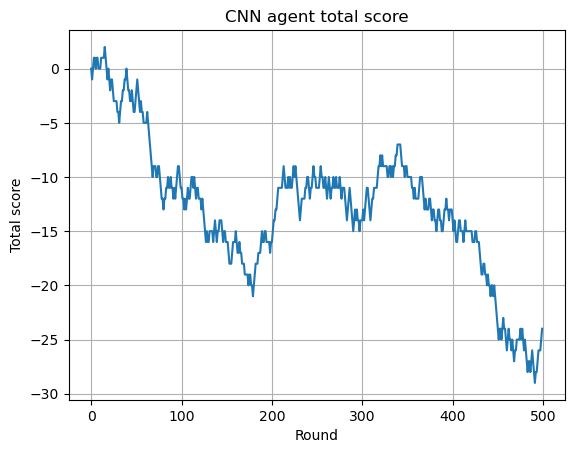

In [51]:
plt.grid()
plt.xlabel('Round')
plt.ylabel('Total score')
plt.title('CNN agent total score')
plt.plot(cnn_scores_new)

It appears that the agent has trouble making correct predictions with the new dataset. The actions are almost random since wins, losses and ties are all close in value.
This can be attributed to one or more of the following cases:
- The two datasets are too different (lack of green screen)
- The agent is overfitted and cannot generalize
- Inconsistent standards regarding rock, paper and scissors labeling (ex. different hand gestures to form scissors)